# Deep Learning with PyTorch


Author: [Anand Saha](http://teleported.in/)

### 2. Building a simple neural network

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.autograd import Variable

# Custom DataSet
from data import iris

### The Dataset and the challenge

![iris](data/iris.jpg)

The **Iris** flower, image source: [Wikimedia](https://en.wikipedia.org/wiki/Iris_(plant))


| sepal_length_cm | sepal_width_cm | petal_length_cm | petal_width_cm | class           |
|-----------------|----------------|-----------------|----------------|-----------------|
| 5.1             | 3.5            | 1.4             | 0.2            | Iris-setosa     |
| 7.0             | 3.2            | 4.7             | 1.4            | Iris-versicolor |
| 6.3             | 3.3            | 6.0             | 2.5            | Iris-virginica  |


* Total instances: 150 (we have separated 20% into validation set, rest into training set)
* Download: [Data Source](https://archive.ics.uci.edu/ml/datasets/iris)

### Let's do a head on the raw file

In [2]:
!head data/iris.data.txt

sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
5.1,3.5,1.4,0.2,Iris-setosa
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,Iris-setosa
5.0,3.6,1.4,0.2,Iris-setosa
5.4,3.9,1.7,0.4,Iris-setosa
4.6,3.4,1.4,0.3,Iris-setosa
5.0,3.4,1.5,0.2,Iris-setosa
4.4,2.9,1.4,0.2,Iris-setosa


### Create the Fully Connected Feed Forward Neural Network

**Create the module**

In [3]:
class IrisNet(nn.Module):
    
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

**Print the module**

In [4]:
model = IrisNet(4, 100, 50, 3)
print(model)

IrisNet(
  (fc1): Linear(in_features=4, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=50, out_features=3, bias=True)
)


### Create the DataLoader

In [5]:
batch_size = 60
iris_data_file = 'data/iris.data.txt'

In [6]:
# Get the datasets
train_ds, test_ds = iris.get_datasets(iris_data_file)

# How many instances have we got?
print('# instances in training set: ', len(train_ds))
print('# instances in testing/validation set: ', len(test_ds))

# Create the dataloaders - for training and validation/testing
# We will be using the term validation and testing data interchangably
train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=True)

# instances in training set:  120
# instances in testing/validation set:  30


### Instantiate the network, the loss function and the optimizer

In [7]:
# Our model
net = IrisNet(4, 100, 50, 3)

# Out loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, nesterov=True, momentum=0.9, dampening=0)  

### Train it!

In [8]:
num_epochs = 500

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):
    
    train_correct = 0
    train_total = 0
    
    for i, (items, classes) in enumerate(train_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        net.train()           # Put the network into training mode
        
        optimizer.zero_grad() # Clear off the gradients from any past operation
        outputs = net(items)  # Do the forward pass
        loss = criterion(outputs, classes) # Calculate the loss
        #print("loss is", loss)
        loss.backward()       # Calculate the gradients with help of back propagation
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients
        
        # Record the correct predictions for training data
        # (increase train_total by number of items in batch)
        train_total += classes.size(0)
        # predicted winds up being array of predicted iris classes, each represented by int
        _, predicted = torch.max(outputs.data, 1)
        # How many predictions were correct in this batch?
        train_correct += (predicted == classes.data).sum()

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, i+1, len(train_ds)//batch_size, loss.item()))

    net.eval()                 # Put the network into evaluation mode
    
    # Book keeping
    # Record the loss (the final one we got down to in current epoch)
    train_loss.append(loss.item())

    # What was our train accuracy?
    train_accuracy.append((100 * train_correct / train_total))
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    test_items = torch.FloatTensor(test_ds.data.values[:, 0:4])
    test_classes = torch.LongTensor(test_ds.data.values[:, 4])

    outputs = net(Variable(test_items))
    loss = criterion(outputs, Variable(test_classes))
    test_loss.append(loss.item())
    _, predicted = torch.max(outputs.data, 1)
    total = test_classes.size(0)
    correct = (predicted == test_classes).sum()
    test_accuracy.append((100 * correct / total))

Epoch 1/500, Iteration 1/2, Loss: 1.2325
Epoch 1/500, Iteration 2/2, Loss: 1.1682
Epoch 2/500, Iteration 1/2, Loss: 1.1822
Epoch 2/500, Iteration 2/2, Loss: 1.1846
Epoch 3/500, Iteration 1/2, Loss: 1.1417
Epoch 3/500, Iteration 2/2, Loss: 1.1808
Epoch 4/500, Iteration 1/2, Loss: 1.1377
Epoch 4/500, Iteration 2/2, Loss: 1.1369
Epoch 5/500, Iteration 1/2, Loss: 1.1073
Epoch 5/500, Iteration 2/2, Loss: 1.1253
Epoch 6/500, Iteration 1/2, Loss: 1.0978
Epoch 6/500, Iteration 2/2, Loss: 1.0959
Epoch 7/500, Iteration 1/2, Loss: 1.0932
Epoch 7/500, Iteration 2/2, Loss: 1.0714
Epoch 8/500, Iteration 1/2, Loss: 1.0706
Epoch 8/500, Iteration 2/2, Loss: 1.0683
Epoch 9/500, Iteration 1/2, Loss: 1.0447
Epoch 9/500, Iteration 2/2, Loss: 1.0710
Epoch 10/500, Iteration 1/2, Loss: 1.0672
Epoch 10/500, Iteration 2/2, Loss: 1.0275
Epoch 11/500, Iteration 1/2, Loss: 1.0386
Epoch 11/500, Iteration 2/2, Loss: 1.0372
Epoch 12/500, Iteration 1/2, Loss: 1.0220
Epoch 12/500, Iteration 2/2, Loss: 1.0358
Epoch 13/5

Epoch 99/500, Iteration 1/2, Loss: 0.4104
Epoch 99/500, Iteration 2/2, Loss: 0.3918
Epoch 100/500, Iteration 1/2, Loss: 0.4198
Epoch 100/500, Iteration 2/2, Loss: 0.3781
Epoch 101/500, Iteration 1/2, Loss: 0.3818
Epoch 101/500, Iteration 2/2, Loss: 0.4102
Epoch 102/500, Iteration 1/2, Loss: 0.3804
Epoch 102/500, Iteration 2/2, Loss: 0.4064
Epoch 103/500, Iteration 1/2, Loss: 0.4077
Epoch 103/500, Iteration 2/2, Loss: 0.3742
Epoch 104/500, Iteration 1/2, Loss: 0.4214
Epoch 104/500, Iteration 2/2, Loss: 0.3551
Epoch 105/500, Iteration 1/2, Loss: 0.3490
Epoch 105/500, Iteration 2/2, Loss: 0.4227
Epoch 106/500, Iteration 1/2, Loss: 0.4320
Epoch 106/500, Iteration 2/2, Loss: 0.3362
Epoch 107/500, Iteration 1/2, Loss: 0.3798
Epoch 107/500, Iteration 2/2, Loss: 0.3825
Epoch 108/500, Iteration 1/2, Loss: 0.3850
Epoch 108/500, Iteration 2/2, Loss: 0.3727
Epoch 109/500, Iteration 1/2, Loss: 0.3594
Epoch 109/500, Iteration 2/2, Loss: 0.3932
Epoch 110/500, Iteration 1/2, Loss: 0.3697
Epoch 110/500

Epoch 203/500, Iteration 2/2, Loss: 0.2059
Epoch 204/500, Iteration 1/2, Loss: 0.1816
Epoch 204/500, Iteration 2/2, Loss: 0.2510
Epoch 205/500, Iteration 1/2, Loss: 0.1976
Epoch 205/500, Iteration 2/2, Loss: 0.2330
Epoch 206/500, Iteration 1/2, Loss: 0.2272
Epoch 206/500, Iteration 2/2, Loss: 0.2021
Epoch 207/500, Iteration 1/2, Loss: 0.2099
Epoch 207/500, Iteration 2/2, Loss: 0.2158
Epoch 208/500, Iteration 1/2, Loss: 0.2087
Epoch 208/500, Iteration 2/2, Loss: 0.2154
Epoch 209/500, Iteration 1/2, Loss: 0.2035
Epoch 209/500, Iteration 2/2, Loss: 0.2185
Epoch 210/500, Iteration 1/2, Loss: 0.2089
Epoch 210/500, Iteration 2/2, Loss: 0.2104
Epoch 211/500, Iteration 1/2, Loss: 0.1861
Epoch 211/500, Iteration 2/2, Loss: 0.2307
Epoch 212/500, Iteration 1/2, Loss: 0.2107
Epoch 212/500, Iteration 2/2, Loss: 0.2044
Epoch 213/500, Iteration 1/2, Loss: 0.2059
Epoch 213/500, Iteration 2/2, Loss: 0.2067
Epoch 214/500, Iteration 1/2, Loss: 0.1964
Epoch 214/500, Iteration 2/2, Loss: 0.2149
Epoch 215/5

Epoch 304/500, Iteration 2/2, Loss: 0.1863
Epoch 305/500, Iteration 1/2, Loss: 0.1248
Epoch 305/500, Iteration 2/2, Loss: 0.1537
Epoch 306/500, Iteration 1/2, Loss: 0.1959
Epoch 306/500, Iteration 2/2, Loss: 0.0823
Epoch 307/500, Iteration 1/2, Loss: 0.1573
Epoch 307/500, Iteration 2/2, Loss: 0.1190
Epoch 308/500, Iteration 1/2, Loss: 0.1188
Epoch 308/500, Iteration 2/2, Loss: 0.1575
Epoch 309/500, Iteration 1/2, Loss: 0.1140
Epoch 309/500, Iteration 2/2, Loss: 0.1609
Epoch 310/500, Iteration 1/2, Loss: 0.1127
Epoch 310/500, Iteration 2/2, Loss: 0.1612
Epoch 311/500, Iteration 1/2, Loss: 0.1290
Epoch 311/500, Iteration 2/2, Loss: 0.1438
Epoch 312/500, Iteration 1/2, Loss: 0.1543
Epoch 312/500, Iteration 2/2, Loss: 0.1178
Epoch 313/500, Iteration 1/2, Loss: 0.1533
Epoch 313/500, Iteration 2/2, Loss: 0.1182
Epoch 314/500, Iteration 1/2, Loss: 0.1564
Epoch 314/500, Iteration 2/2, Loss: 0.1138
Epoch 315/500, Iteration 1/2, Loss: 0.1452
Epoch 315/500, Iteration 2/2, Loss: 0.1242
Epoch 316/5

Epoch 400/500, Iteration 2/2, Loss: 0.0815
Epoch 401/500, Iteration 1/2, Loss: 0.0781
Epoch 401/500, Iteration 2/2, Loss: 0.1395
Epoch 402/500, Iteration 1/2, Loss: 0.1242
Epoch 402/500, Iteration 2/2, Loss: 0.0929
Epoch 403/500, Iteration 1/2, Loss: 0.0806
Epoch 403/500, Iteration 2/2, Loss: 0.1381
Epoch 404/500, Iteration 1/2, Loss: 0.1032
Epoch 404/500, Iteration 2/2, Loss: 0.1135
Epoch 405/500, Iteration 1/2, Loss: 0.1115
Epoch 405/500, Iteration 2/2, Loss: 0.1069
Epoch 406/500, Iteration 1/2, Loss: 0.1137
Epoch 406/500, Iteration 2/2, Loss: 0.1022
Epoch 407/500, Iteration 1/2, Loss: 0.0936
Epoch 407/500, Iteration 2/2, Loss: 0.1221
Epoch 408/500, Iteration 1/2, Loss: 0.1344
Epoch 408/500, Iteration 2/2, Loss: 0.0819
Epoch 409/500, Iteration 1/2, Loss: 0.1023
Epoch 409/500, Iteration 2/2, Loss: 0.1119
Epoch 410/500, Iteration 1/2, Loss: 0.1133
Epoch 410/500, Iteration 2/2, Loss: 0.1005
Epoch 411/500, Iteration 1/2, Loss: 0.0791
Epoch 411/500, Iteration 2/2, Loss: 0.1356
Epoch 412/5

Epoch 496/500, Iteration 2/2, Loss: 0.0847
Epoch 497/500, Iteration 1/2, Loss: 0.0908
Epoch 497/500, Iteration 2/2, Loss: 0.0959
Epoch 498/500, Iteration 1/2, Loss: 0.0681
Epoch 498/500, Iteration 2/2, Loss: 0.1187
Epoch 499/500, Iteration 1/2, Loss: 0.1159
Epoch 499/500, Iteration 2/2, Loss: 0.0700
Epoch 500/500, Iteration 1/2, Loss: 0.0792
Epoch 500/500, Iteration 2/2, Loss: 0.1063


Plot loss vs iterations

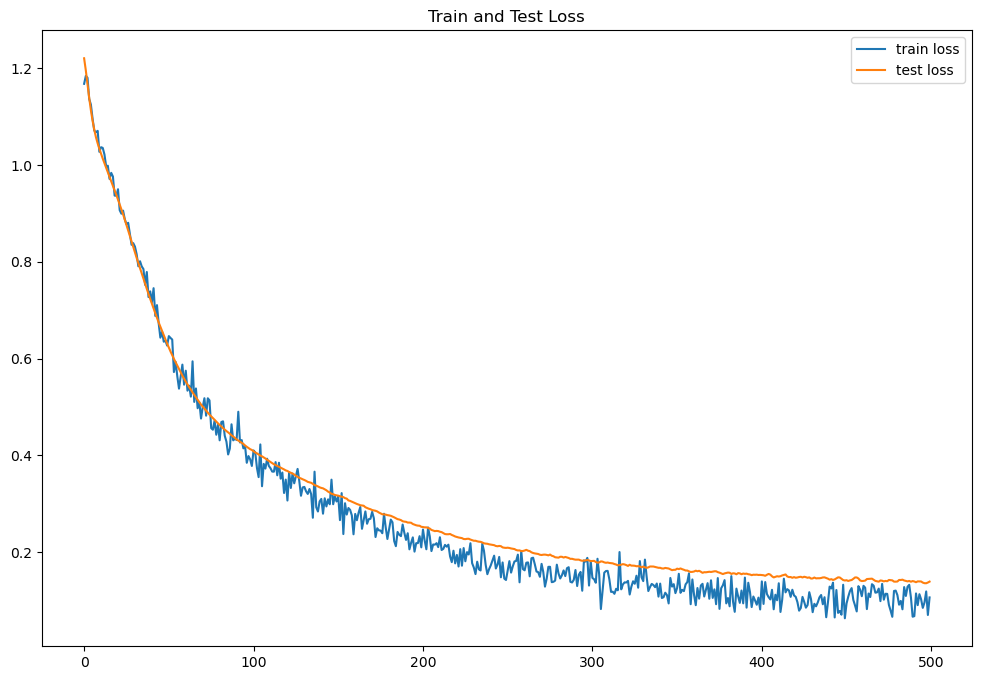

In [9]:
fig = plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.title("Train and Test Loss")
plt.legend()
plt.show()

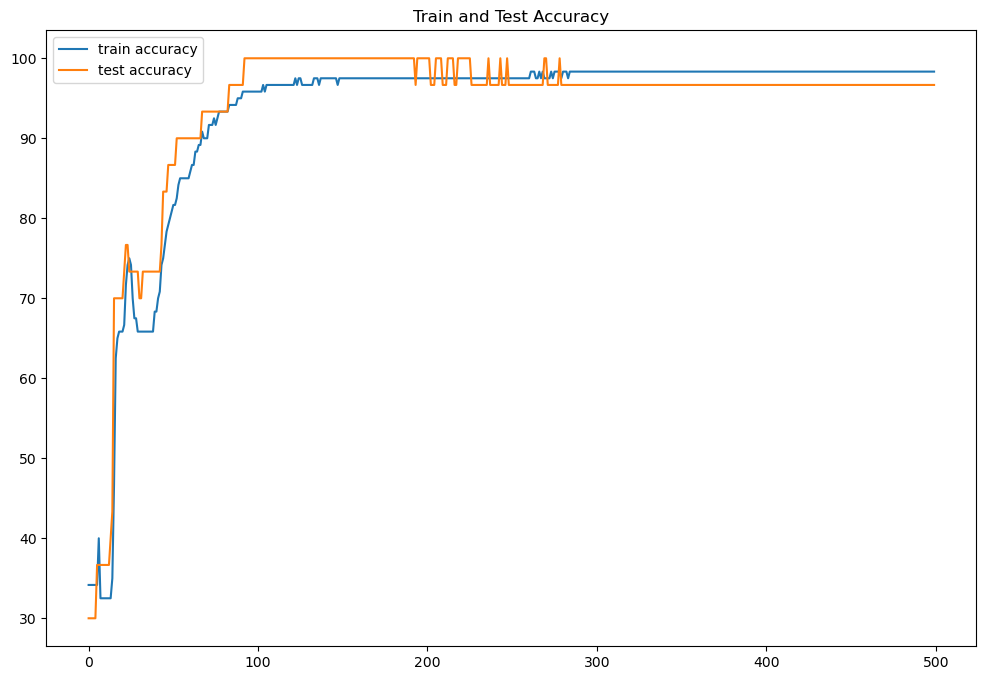

In [10]:
fig = plt.figure(figsize=(12, 8))
plt.plot(train_accuracy, label='train accuracy')
plt.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
plt.legend()
plt.show()

### Saving the model to disk, and loading it back

In [11]:
torch.save(net.state_dict(), "./2.model.pth")

In [12]:
net2 = IrisNet(4, 100, 50, 3)
net2.load_state_dict(torch.load("./2.model.pth"))

<All keys matched successfully>

In [13]:
output = net2(Variable(torch.FloatTensor([[5.1, 3.5, 1.4, 0.2]])))

In [14]:
_, predicted_class = torch.max(output.data, 1)
print('Predicted class: ', predicted_class.numpy()[0])
print('Expected class: ', 0 )

Predicted class:  0
Expected class:  0
